# Feature Engineering:

Feature Engineering is the process of selecting, creating or modifying features like input variables or data to help machine learning models learn patterns more effectively

# Steps include the Feature Engineering:

 1>Feature Creation.
 2>Feature Transformation.
 3>Feature Extraction.
 4>Feature Selection.
 5>Feature Scaling.

# importing Libraries and Load Data:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 

# Load the dataset
df = pd.read_csv('Salary_Dataset_DataScienceLovers.csv') 

print(df.head())
print(df.info())

   Rating                      Company Name          Job Title   Salary  \
0     3.8                            Sasken  Android Developer   400000   
1     4.5  Advanced Millennium Technologies  Android Developer   400000   
2     4.0                         Unacademy  Android Developer  1000000   
3     3.8                SnapBizz Cloudtech  Android Developer   300000   
4     4.4            Appoids Tech Solutions  Android Developer   600000   

   Salaries Reported   Location Employment Status Job Roles  
0                  3  Bangalore         Full Time   Android  
1                  3  Bangalore         Full Time   Android  
2                  3  Bangalore         Full Time   Android  
3                  3  Bangalore         Full Time   Android  
4                  3  Bangalore         Full Time   Android  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22770 entries, 0 to 22769
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------          

# Data Cleaning:

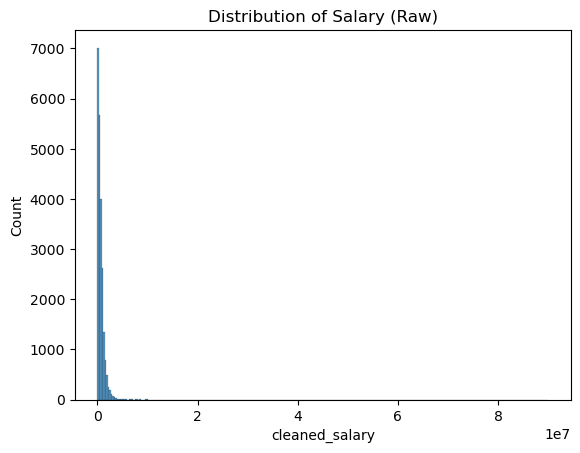

In [3]:
def clean_salary(salary):
    if pd.isna(salary):
        return np.nan
   
    s = str(salary).lower()
    
    # Remove symbols like ₹, $, commas
    s = re.sub(r'[^\d\.]', '', s)
    
    # Handle empty strings
    if s == '': 
        return np.nan
        
    return float(s)

# Apply the cleaning
df['cleaned_salary'] = df['Salary'].apply(clean_salary)

# Drop rows where salary couldn't be parsed
df = df.dropna(subset=['cleaned_salary'])

# Visualize the Target
sns.histplot(df['cleaned_salary'])
plt.title("Distribution of Salary (Raw)")
plt.show()

# Text Feature Extraction (Job Title):

In [4]:
def extract_seniority(title):
    title = str(title).lower()
    if 'sr' in title or 'senior' in title or 'lead' in title or 'principal' in title:
        return 'Senior'
    elif 'jr' in title or 'junior' in title or 'intern' in title:
        return 'Junior'
    else:
        return 'Mid-Level' 

df['Seniority'] = df['Job Title'].apply(extract_seniority)

print(df['Seniority'].value_counts())

Seniority
Mid-Level    17505
Junior        2718
Senior        2547
Name: count, dtype: int64


# We reduced thousands of job titles into 3 distinct categories that clearly correlate with salary...

# Categorical Grouping (Location)::

In [5]:
# Calculate frequency
location_counts = df['Location'].value_counts()

# Select top 10
top_10_locations = location_counts.head(10).index

# Apply grouping
df['Location_Grouped'] = df['Location'].apply(lambda x: x if x in top_10_locations else 'Other')

print(df['Location_Grouped'].value_counts())

Location_Grouped
Bangalore         8264
Hyderabad         4467
New Delhi         4176
Chennai           2458
Pune              2134
Mumbai             749
Kolkata            178
Madhya Pradesh     155
Kerala             108
Jaipur              81
Name: count, dtype: int64


 # Categorical Grouping,  It prevents from "Curse of Dimensionality." If we didn't do this, One-Hot Encoding would create hundreds of columns...
 

# One-Hot Encoding:

In [13]:
df_encoded = pd.get_dummies(df, columns=['Employment Status', 'Seniority', 'Location_Grouped'], drop_first=True)

print("Columns after encoding:", df_encoded.columns)


Columns after encoding: Index(['Rating', 'Company Name', 'Job Title', 'Salary', 'Salaries Reported',
       'Location', 'Job Roles', 'cleaned_salary',
       'Employment Status_Full Time', 'Employment Status_Intern',
       'Employment Status_Trainee', 'Seniority_Mid-Level', 'Seniority_Senior',
       'Location_Grouped_Chennai', 'Location_Grouped_Hyderabad',
       'Location_Grouped_Jaipur', 'Location_Grouped_Kerala',
       'Location_Grouped_Kolkata', 'Location_Grouped_Madhya Pradesh',
       'Location_Grouped_Mumbai', 'Location_Grouped_New Delhi',
       'Location_Grouped_Pune'],
      dtype='object')


# Target Transformation :

Salary data is usually "Right Skewed" (most people earn average, a few earn millions). This confuses linear models.
Solution-->Apply Log Transformation to make the data look more "Normal".

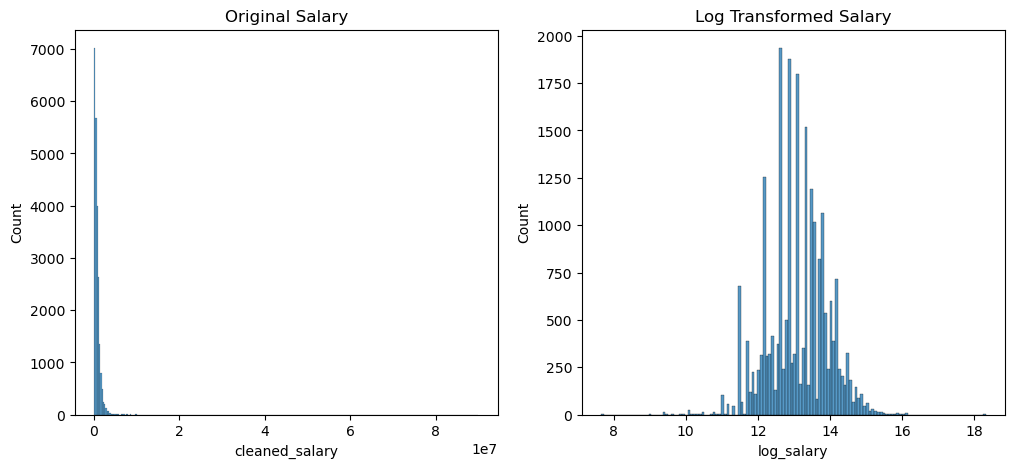

In [14]:
# Create new target feature
df_encoded['log_salary'] = np.log1p(df_encoded['cleaned_salary'])

# Compare Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_encoded['cleaned_salary'], ax=ax[0]).set_title('Original Salary')
sns.histplot(df_encoded['log_salary'], ax=ax[1]).set_title('Log Transformed Salary')
plt.show()

# Linear Regression assumes data is normally distributed. This transformation satisfies that assumption and reduces the impact of massive outliers.

# Model Comparison ::

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

cols_to_drop = [
    'cleaned_salary', 'log_salary',  
    'Salary', 'Job Title', 'Company Name', 'Location', 'Job Roles' 
]


existing_cols_to_drop = [c for c in cols_to_drop if c in df_encoded.columns]
X = df_encoded.drop(existing_cols_to_drop, axis=1)

# We train on the Log Transformed target
y = df_encoded['log_salary'] 

# 2. Split the data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)


def evaluate_model(model, X_test, y_test, model_name):
 
    y_pred_log = model.predict(X_test)
    
 
    y_pred_actual = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
 
    r2 = r2_score(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    
    print(f"--- {model_name} Performance ---")
    print(f"R2 Score (Accuracy): {r2:.4f}")
    print(f"MAE (Avg Error):     {mae:.2f}")
    print(f"RMSE (Root Sq Error):{rmse:.2f}\n")
    
    return y_test_actual, y_pred_actual, r2, mae, rmse

# --- Model 1: Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_actual, lr_preds, lr_r2, lr_mae, lr_rmse = evaluate_model(lr_model, X_test, y_test, "Linear Regression")

# --- Model 2: Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_actual, rf_preds, rf_r2, rf_mae, rf_rmse = evaluate_model(rf_model, X_test, y_test, "Random Forest")


Training Shape: (18216, 16)
Testing Shape: (4554, 16)
--- Linear Regression Performance ---
R2 Score (Accuracy): 0.0143
MAE (Avg Error):     373389.63
RMSE (Root Sq Error):632206.75

--- Random Forest Performance ---
R2 Score (Accuracy): 0.0261
MAE (Avg Error):     375093.51
RMSE (Root Sq Error):628415.03



/var/folders/df/zjxmm8zd4dj1w8pl402xp5140000gn/T/ipykernel_3689/2742457754.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2 Score', data=results, ax=axes[0], palette='viridis')
/var/folders/df/zjxmm8zd4dj1w8pl402xp5140000gn/T/ipykernel_3689/2742457754.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results, ax=axes[1], palette='magma')


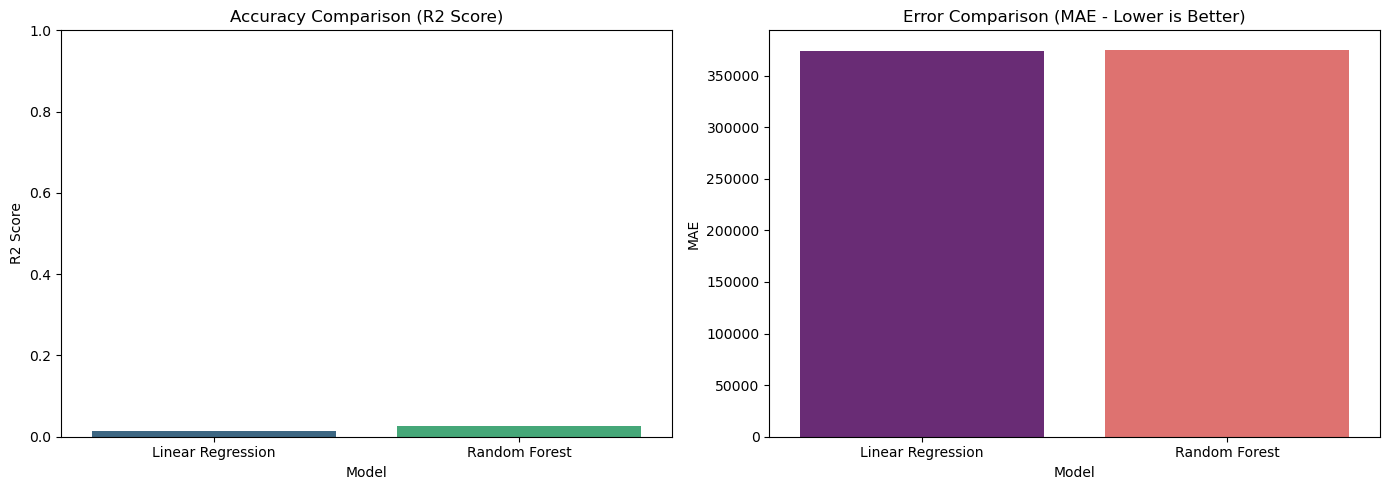

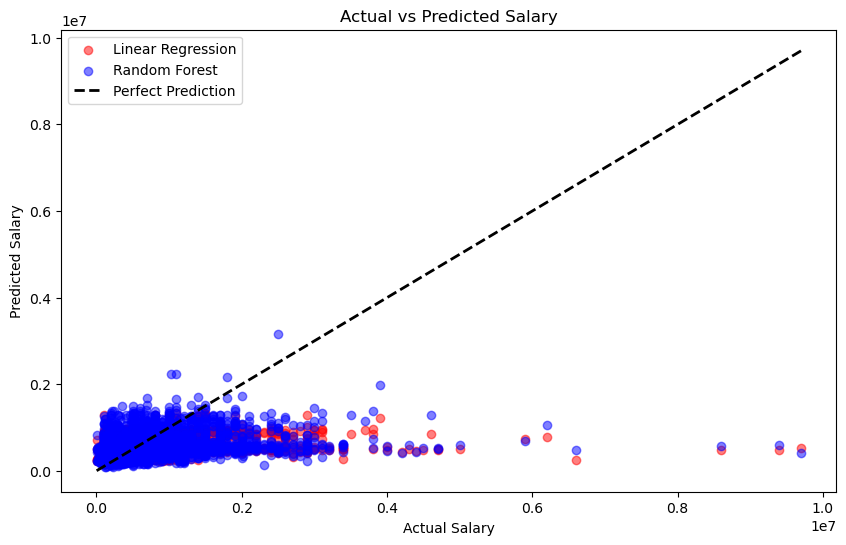

In [ ]:
# Create a DataFrame for easy plotting
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [lr_r2, rf_r2],
    'MAE': [lr_mae, rf_mae],
    'RMSE': [lr_rmse, rf_rmse]
})

# pplot1:Metrics Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R2 Score :
sns.barplot(x='Model', y='R2 Score', data=results, ax=axes[0], palette='viridis')
axes[0].set_title('Accuracy Comparison (R2 Score)')
axes[0].set_ylim(0, 1)

# MAE (Error)
sns.barplot(x='Model', y='MAE', data=results, ax=axes[1], palette='magma')
axes[1].set_title('Error Comparison (MAE - Lower is Better)')

plt.tight_layout()
plt.show()

# Plot 2: Actual vs Predicted Scatter Plot:
plt.figure(figsize=(10, 6))
plt.scatter(y_actual, lr_preds, alpha=0.5, color='red', label='Linear Regression')
plt.scatter(y_actual, rf_preds, alpha=0.5, color='blue', label='Random Forest')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2, label='Perfect Prediction')

plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salary')
plt.legend()
plt.show()

# Why Transformation is Required:

Parsing: The Salary column was text string data. Models cannot do math on strings.

Cardinality Reduction: Location and Job Title had too many unique values. Grouping them helps the model generalize rather than memorize specific rows.

Skewness: Financial data is almost always skewed. Transforming the target variable helps linear models perform better.



# Which Models Benefit:



# 1>Linear Regression / Logistic Regression:

 These profit heavily from One-Hot Encoding and Log Transformation (Normality).


# 2> Tree Models (Random Forest/XGBoost): 
These profit from the "Feature Extraction" (extracting 'Senior' vs 'Junior'), as it makes the decision splits much cleaner.